[View in Colaboratory](https://colab.research.google.com/github/InnovArul/nettutorial/blob/master/deep-ai-explanation/deep_explanation.ipynb)

## **PyTorch installation**

In [34]:
# install torch
!pip3 uninstall torchvision torch -y
!pip3 install torchvision
!pip3 install tqdm
!pip install --no-cache-dir -I pillow

# http://pytorch.org/
from os import path
import os
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'


Uninstalling torchvision-0.2.1:
  Successfully uninstalled torchvision-0.2.1
Uninstalling torch-0.4.0:
  Successfully uninstalled torch-0.4.0
  Using cached https://files.pythonhosted.org/packages/ca/0d/f00b2885711e08bd71242ebe7b96561e6f6d01fdb4b9dcf4d37e2e13c5e1/torchvision-0.2.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/69/43/380514bd9663f1bf708abeb359b8b48d3fabb1c8e95bb3427a980a064c57/torch-0.4.0-cp36-cp36m-manylinux1_x86_64.whl
tcmalloc: large alloc 1073750016 bytes == 0x5b9e6000 @  0x7fcb10fbe1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 2.0MB 22.0MB/s 


## Google drive connection


In [3]:

# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


## Sanity check

Check torch installation, google drive connection

In [35]:
# check torch
import torch, os
print(torch.cuda.is_available())
print(os.listdir('.'))


True
['datalab', 'nettutorial', '.gdfuse', '.ipython', '.config', '.torch', '.cache', '.nv', '.forever', '.gitconfig', '.local', 'drive']


## Git repo cloning

In [5]:
!git clone https://github.com/InnovArul/nettutorial drive/colab/nettutorial

Cloning into 'drive/colab/nettutorial'...
remote: Counting objects: 168, done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 168 (delta 0), reused 0 (delta 0), pack-reused 164
Receiving objects: 100% (168/168), 1.26 MiB | 155.00 KiB/s, done.
Resolving deltas: 100% (78/78), done.
Checking out files: 100% (31/31), done.


## Import relevant packages

In [0]:
# inspired from https://github.com/roberto1648/deep-explanation-using-ai-for-explaining-the-results-of-ai
# https://arxiv.org/abs/1704.03296

%matplotlib inline

# import statements
import torch, os, sys
import torch.nn as nn, numpy as np
import torch.nn.functional as F
import torchvision, torchvision.models as models
import matplotlib.pyplot as plt, numpy as np
from skimage import io, transform, morphology
from tqdm import tqdm
from torch.autograd import Variable

# ignore warnings
import warnings
warnings.filterwarnings('ignore')



## Global variables

In [0]:
# hyper parameters
root_folder = 'drive/colab/nettutorial/deep-ai-explanation'
image_path = os.path.join(root_folder, 'data/image_samples/cat2.jpg')
kernel_size = 3
n_blocks = 3
n_layers = 3
epochs = 1000
lr = 0.01
l1_coeff = 100.0
center_of_mass = True


## API to load image

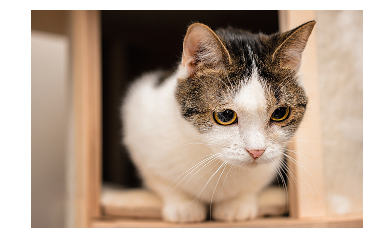

In [3]:
import scipy.misc
def load_image(img_path, show_image=True):
    img = scipy.misc.imread(img_path)
    
    if show_image:
        fig = plt.figure('image')
        plt.imshow(img)
        plt.axis('off')
    
    return img

img_np = load_image(image_path)

## API to convert from pytorch variable to np image

In [0]:
# helper functions
def use_cuda():
    return torch.cuda.is_available()

def image_torch_to_np(img, show_image=True):
    np_img = img.data.cpu().numpy()[0]
    np_img = np_img.transpose((1,2,0))
    
    # BGR to RGB
    np_img = np_img[:,:,::-1].copy()
    
    if show_image:
        fig = plt.figure('image')
        plt.imshow(np_img)
        plt.axis('off')
        plt.show()
    return np_img


## Load the model

In [0]:

# load the model
def load_model(model_type='vgg16'):
    model = getattr(models, model_type)(pretrained=True)
    model.eval()
    
    if use_cuda():
        model = model.cuda()
    
    for p in model.features.parameters():
        p.requires_grad = False
    for p in model.classifier.parameters():
        p.requires_grad = False
       
    return model

model = load_model('vgg16')
#print(model)

## To convert np image to pytorch variable

In [6]:
def image_np_to_torch(img):
    print((img.min(), img.max()))
    resized_img = np.float32(transform.resize(img, (224, 224)))[:,:,::-1].copy()
    print((resized_img.min(), resized_img.max()))
    
    resized_img = torch.from_numpy(resized_img.transpose((2,0,1))).unsqueeze(0)
    if use_cuda():
        resized_img = resized_img.cuda()
    
    return Variable(resized_img, requires_grad=True)

img_torch = image_np_to_torch(img_np)
print(type(img_torch))
print(img_torch.shape)
print((img_torch.min(), img_torch.max()))
    
    
    

(0, 253)
(0.0009819553, 0.9837351)
<class 'torch.Tensor'>
torch.Size([1, 3, 224, 224])
(tensor(1.00000e-04 *
       9.8196, device='cuda:0'), tensor(0.9837, device='cuda:0'))


## Normalize image for torchvision pretrained models

In [0]:
def normalize_torch_img(img):
    means=[0.485, 0.456, 0.406]
    stds=[0.229, 0.224, 0.225]
    img = img.clone()
    for i in range(img.shape[1]):
        img[0,i] = (img[0,i] - means[i]) / stds[i]
    
    return img

## Some visualization

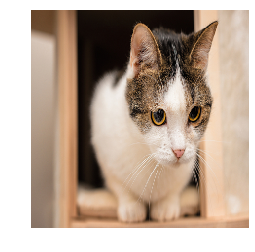

(0.0009819553, 0.9837351)
(224, 224, 3)


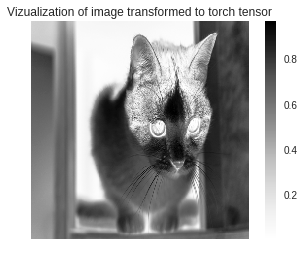

In [8]:
# visualize scaling changes
img_np_resized = image_torch_to_np(img_torch)
print((np.min(img_np_resized), np.max(img_np_resized)))
print(img_np_resized.shape)
img_avg = np.mean(img_np_resized, axis=2)

plt.pcolormesh(img_avg[::-1, :])
plt.colorbar()
plt.axis('off')
ax = plt.gca()
ax.set_aspect(1)
__ = plt.title("Vizualization of image transformed to torch tensor")

## Forward the input image and print top-5 classes

In [9]:
import pickle
vgg_class = []

def assess_input(input_img, model):
    global vgg_class
    with open(os.path.join(root_folder, "data/imagenet1000_clsid_to_human.pkl"), "rb") as fp:
        vgg_class = pickle.load(fp)
       
    outputs = F.softmax(model(normalize_torch_img(input_img)))
    outputs_np = outputs.data.cpu().numpy()
    sorted_args = np.argsort(outputs_np[0, :])[::-1]
    
    print('top 5 classes')
    print('(index) description : score')
    
    for i in sorted_args[:5]:
        print('({}) {} : {}'.format(i, vgg_class[i], outputs_np[0,i]))
    
    if outputs_np[0, sorted_args[0]] < 0.5:
        print("*** Warning ***")
        print("top category score under 0.5, extracted explanation may not be accurate on not well defined class")


assess_input(img_torch, model)
    

top 5 classes
(index) description : score
(285) Egyptian cat : 0.8464415073394775
(281) tabby, tabby cat : 0.06086096540093422
(904) window screen : 0.032634079456329346
(282) tiger cat : 0.017227599397301674
(728) plastic bag : 0.006624131929129362


## A class to perturb the given image (range of [0 ... 1])

In [0]:
class PerturbationGenerator(nn.Module):
    def __init__(self, kernel_size=3, n_blocks=3, n_layers=3):
        super(PerturbationGenerator, self).__init__()
        
        # if kernel_size is even
        if kernel_size % 2 == 0:
            kernel_size = kernel_size + 1
        
        self.conv = nn.Conv2d(3, 3, kernel_size=kernel_size, padding=kernel_size//2)
        self.n_blocks = n_blocks
        self.n_layers = n_layers

    def forward(self, x):
        
        # get scaling information
        x_min = torch.min(x)
        Dx_max = torch.max(x - x_min)
        
        # perform manipulation
        for _ in range(self.n_blocks * self.n_layers):
            x = self.conv(x)
            #print(x.shape)
        
        # rescale the manipulated output
        x = (x - torch.min(x)) / (torch.max(x) - torch.min(x)) # x : 0 to 1
        x = (x * Dx_max) + x_min # x : original xmin to xmax

        return x

# create an instance
img_perturber = PerturbationGenerator(kernel_size, n_blocks, n_layers).cuda()


## Training routine to train perturber model

  0%|          | 1/1000 [00:00<01:43,  9.67it/s]

category of highest probability 285 Egyptian cat
optimizing the perturber


100%|██████████| 1000/1000 [01:12<00:00, 13.75it/s]


original score: 0.8464415073394775
perturbed score: 0.005414185114204884


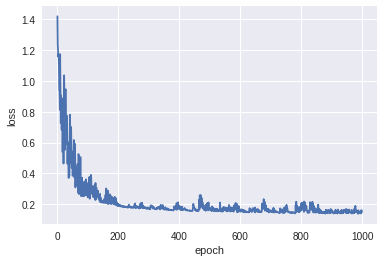

In [11]:
import torch.optim as optim

def get_optimum_perturbation(epochs, model, perturber, img, lr=0.1, l1_coeff=0.01):
    optimizer = optim.Adam(perturber.parameters(), lr=lr)
    
    # get the max output
    output = F.softmax(model(img))
    max_category = np.argmax(output.cpu().data.numpy())
    print('category of highest probability', max_category, vgg_class[max_category])
    losses = []
    
    # optimize the perturber for getting adversarial image
    print('optimizing the perturber')
    for _ in tqdm(range(epochs)):
        perturbed_img = perturber(img)
        #print((img.shape, perturbed_img.shape))
        norm_image = normalize_torch_img(perturbed_img)
        output = F.softmax(model(norm_image))
        color_img_diff = perturbed_img - img
        norm_img_diff = normalize_torch_img(img) - norm_image
        loss = torch.mean(torch.abs(color_img_diff)) + output[0, max_category] + torch.mean(torch.abs(norm_img_diff))
        losses.append(loss.data[0])
        
        # optimize 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
   
    # plot the loss
    plt.figure("loss")
    plt.plot(losses)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    
    print("original score: {}".format(F.softmax(model(normalize_torch_img(img)))[0, max_category]))
    print("perturbed score: {}".format(F.softmax(model(normalize_torch_img(perturbed_img)))[0, max_category]))
    return perturbed_img


perturbed_img = get_optimum_perturbation(
    epochs, model, img_perturber, img_torch,
    lr=lr, l1_coeff=l1_coeff,
)

## Plot the result images

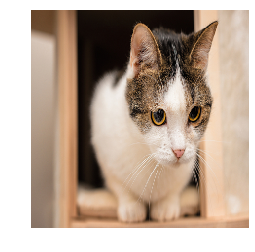

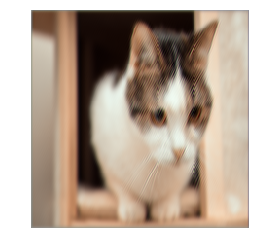

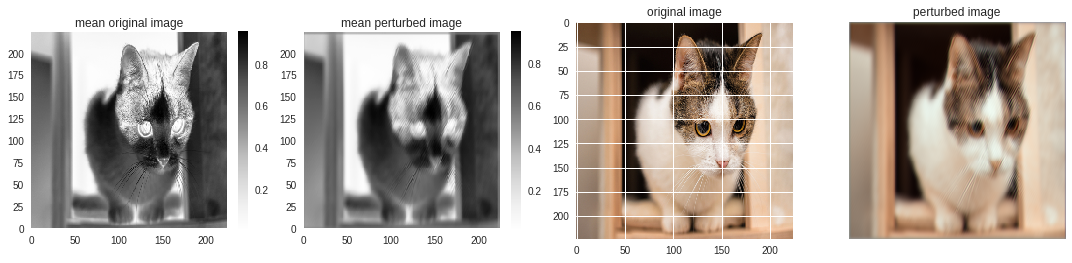

In [12]:
original_img_np = image_torch_to_np(img_torch)
perturbed_img_np = image_torch_to_np(perturbed_img)

mean_original_np = np.mean(original_img_np, axis=2)
mean_perturbed_np = np.mean(perturbed_img_np, axis=2)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(15, 5))
fig.canvas.set_window_title("images")

im1 = ax1.pcolormesh(mean_original_np[::-1, :])
fig.colorbar(im1, ax=ax1, fraction=0.046)
ax1.set_aspect(1)
plt.axis('off')
ax1.set_title("mean original image")

im2 = ax2.pcolormesh(mean_perturbed_np[::-1,:])
fig.colorbar(im2, ax=ax2, fraction=0.046)
plt.axis('off')
ax2.set_aspect(1)
ax2.set_title("mean perturbed image")

ax3.imshow(original_img_np)
ax3.set_aspect(1)
ax3.set_title("original image")
plt.axis('off')

ax4.imshow(perturbed_img_np)
plt.axis('off')
ax4.set_aspect(1)
ax4.set_title("perturbed image")

fig.tight_layout()
plt.show()


## Difference calculations

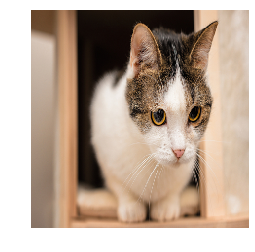

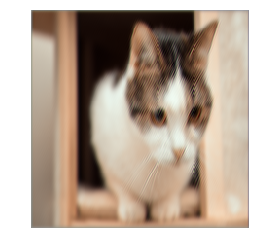

In [13]:
def post_processing(original_img, perturbed_img):
    original_img_np = image_torch_to_np(original_img)
    perturbed_img_np = image_torch_to_np(perturbed_img)

    mean_original_np = np.mean(original_img_np, axis=2)
    mean_perturbed_np = np.mean(perturbed_img_np, axis=2)    
    diff = (mean_original_np - mean_perturbed_np)**6
    
    # remove perturbations in the edges of image
    h, w = np.shape(diff)
    diff[:int(0.1 * h), :] = 0
    diff[int(0.9 * h):, :] = 0
    diff[:, :int(0.1 * w)] = 0
    diff[:, int(0.9 * w):] = 0
    
    # dilate the important points left for visibility:
    square = np.ones((20, 20))
    diff = morphology.dilation(diff, square)
    return diff, original_img_np, perturbed_img_np, mean_original_np, mean_perturbed_np
    
    
diff, original_img_np, perturbed_img_np, mean_original_np, mean_perturbed_np = post_processing(img_torch, perturbed_img)

## Plotting the results

(0.0009819553, 0.9837351)
(0.0009819553, 0.9837351)
(0.0033788516, 0.9640495)
(0.013523781, 0.9576244)


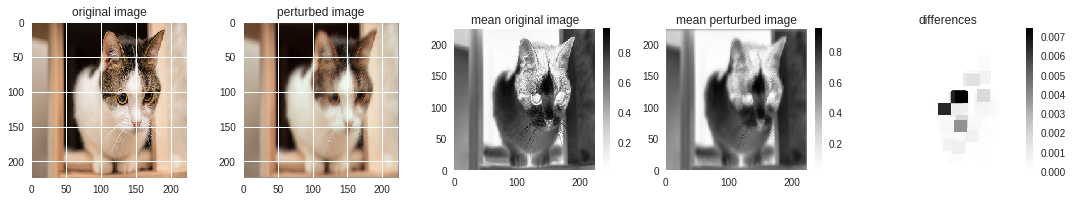

In [14]:
from scipy.ndimage import center_of_mass
def plot_results(diff, original_img_np, perturbed_img_np, mean_original_np, mean_perturbed_np, indicate_center_of_mass=False):
    center_mass = center_of_mass(diff)
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, figsize=(15, 5))

    print((np.min(original_img_np), np.max(original_img_np)))
    im1 = ax1.imshow(original_img_np)
    ax1.set_aspect(1)
    plt.axis('off')
    ax1.set_title('original image')
    
    print((np.min(perturbed_img_np), np.max(perturbed_img_np)))
    im2 = ax2.imshow(perturbed_img_np)
    ax2.set_aspect(1)
    plt.axis('off')
    ax2.set_title('perturbed image')    
    
    print((np.min(mean_original_np), np.max(mean_original_np)))
    im3 = ax3.pcolormesh(mean_original_np[::-1, :])
    fig.colorbar(im3, ax=ax3, fraction=0.046)
    ax3.set_aspect(1)
    plt.axis('off')
    ax3.set_title('mean original image')
    
    print((np.min(mean_perturbed_np), np.max(mean_perturbed_np)))
    im4 = ax4.pcolormesh(mean_perturbed_np[::-1, :])
    fig.colorbar(im4, ax=ax4, fraction=0.046)
    ax4.set_aspect(1)
    plt.axis('off')
    ax4.set_title('mean perturbed image')
    
    im5 = ax5.pcolormesh(diff)
    fig.colorbar(im5, ax=ax5, fraction=0.046)
    ax5.set_aspect(1)
    plt.axis('off')
    ax5.set_title('differences')    
    
    if indicate_center_of_mass:
        ax3.annotate("X: center of mass", center_mass) 
        
    fig.tight_layout()
    plt.show()

plot_results(diff, original_img_np, perturbed_img_np, mean_original_np, mean_perturbed_np, indicate_center_of_mass=False)

## API to handle the flow

In [0]:
def deep_explanation(image_path="drive/image_samples/car.jpg",
                    kernel_size=3,
                    nblocks=2,
                    nlayers=3,
                    epochs=1000,
                    lr=0.1,
                    l1_coeff=1.0,
                    indicate_center_of_mass=True,):
    model = load_model().cuda()
    #print(model)

    img_np = load_image(image_path)
    img_torch = image_np_to_torch(img_np).cuda()
    assess_input(img_torch, model)
    img_perturber = PerturbationGenerator(kernel_size, n_blocks, n_layers).cuda()
    perturbed_img = get_optimum_perturbation(
        epochs, model, img_perturber, img_torch,
        lr=lr, l1_coeff=l1_coeff,
    )

    diff, original_img_np, perturbed_img_np, mean_original_np, mean_perturbed_np = post_processing(img_torch, perturbed_img)
    plot_results(diff, original_img_np, perturbed_img_np, mean_original_np, mean_perturbed_np, indicate_center_of_mass=False)
    

## Instance

  0%|          | 0/1000 [00:00<?, ?it/s]

(0, 255)
(0.0, 1.0)
top 5 classes
(index) description : score
(751) racer, race car, racing car : 0.5377611517906189
(817) sports car, sport car : 0.30807310342788696
(479) car wheel : 0.10326066613197327
(436) beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon : 0.025397760793566704
(511) convertible : 0.015455670654773712
category of highest probability 751 racer, race car, racing car
optimizing the perturber


100%|██████████| 1000/1000 [01:13<00:00, 13.62it/s]


original score: 0.5377611517906189
perturbed score: 0.005767825059592724


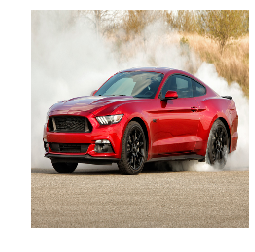

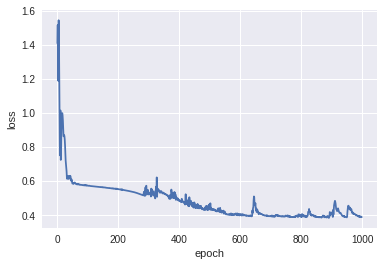

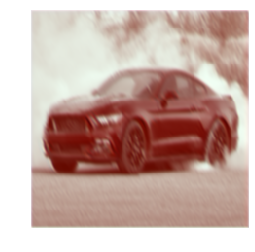

(0.0, 1.0)
(0.0, 1.0)
(0.0, 0.9923728)
(0.13772802, 0.9705081)


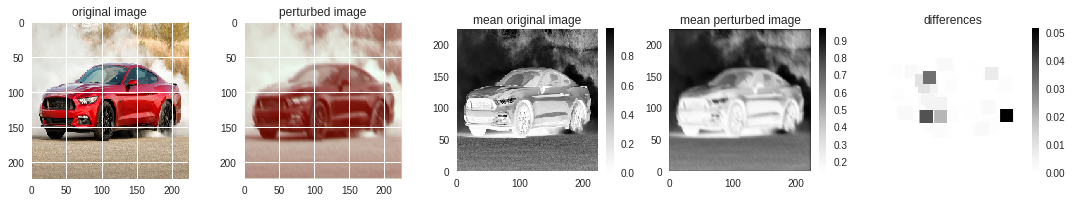

In [16]:
deep_explanation(image_path=os.path.join(root_folder, "data/image_samples/car.jpg"),
                    kernel_size=3,
                    nblocks=2,
                    nlayers=3,
                    epochs=1000,
                    lr=0.1,
                    l1_coeff=1000.0,
                    indicate_center_of_mass=True,)